In [6]:
import json
import os
import subprocess

import numpy as np
from pathlib import Path
import yaml
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.ticker import MaxNLocator
import lossmaps as lm
import xobjects as xo

import xtrack as xt
import xcoll as xc

import lossmaps as lm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import xarray as xr

# LOAD LINE

In [2]:
def find_axis_intercepts(x_coords, y_coords):
    x_intercepts = []
    y_intercepts = []

    for i in range(len(x_coords)):
        x1, y1 = x_coords[i], y_coords[i]
        x2, y2 = x_coords[(i + 1) % len(x_coords)], y_coords[(i + 1) % len(y_coords)]

        if x1 == x2:
        # Vertical line, no y-intercept
            y_intercept = 0.0 if x1 == x2 == 0.0 else None
        else:
            slope = (y2 - y1) / (x2 - x1)
            y_intercept = y1 - (slope * x1)

        if y1 == y2:
        # Horizontal line, no x-intercept
            x_intercept = 0.0 if y1 == y2 == 0.0 else None
        else:
            slope = (x2 - x1) / (y2 - y1)
            x_intercept = x1 - (slope * y1)

        # Check if the x-intercept is within the range of x1 and x2
        if x_intercept is not None and (x1 <= x_intercept <= x2 or x2 <= x_intercept <= x1):
            x_intercepts.append(x_intercept)

        # Check if the y-intercept is within the range of y1 and y2
        if y_intercept is not None and (y1 <= y_intercept <= y2 or y2 <= y_intercept <= y1):
            y_intercepts.append(y_intercept)

    return x_intercepts, y_intercepts



def find_bad_offset_apertures(line):
    aperture_offsets = {}
    for name, element in line.element_dict.items():
        if 'offset' in name and element.__class__.__name__.startswith('XYShift'):
            aper_name = name.split('_offset')[0]
            aperture_offsets[aper_name] = (element.dx, element.dy)

    bad_apers = {}
    print('vmabc.4l2.b.b2_aper' in aperture_offsets.keys())
    for ap_name, offset in aperture_offsets.items():
        aperture_el = line.element_dict[ap_name]

        cname= aperture_el.__class__.__name__
        ap_dict = aperture_el.to_dict()

        if cname == 'LimitEllipse':
            x_min = -ap_dict['a']
            x_max = ap_dict['a']
            y_min = -ap_dict['b']
            y_max = ap_dict['b']
        elif cname == 'LimitRect':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRectEllipse':
            x_min = -ap_dict['max_x']
            x_max = ap_dict['max_x']
            y_min = -ap_dict['max_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRacetrack':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitPolygon':
            x_intercepts, y_intercepts = find_axis_intercepts(ap_dict['x_vertices'],
                                                            ap_dict['y_vertices'])
            x_min = min(x_intercepts)
            x_max = max(x_intercepts)
            y_min = min(y_intercepts)
            y_max = max(y_intercepts)

        tolerance = 5e-3
        """if (x_max - offset[0] < tolerance 
            or -x_min + offset[0] < tolerance 
            or y_max - offset[1] < tolerance 
            or -y_min + offset[1] < tolerance):"""
        if (offset[0] -x_max > tolerance 
            or  -offset[0] + x_min > tolerance 
            or  offset[1] - y_max > tolerance 
            or  -offset[1] + y_min > tolerance ):
                bad_apers[ap_name] = (x_min, x_max, y_min, y_max, offset[0], offset[1])

    return bad_apers



In [3]:
    config_file ='config_sim.yaml'

    with open(config_file, 'r') as stream:
        config_dict = yaml.safe_load(stream)



    run_dict = config_dict['run']
    file_dict = config_dict['input_files']


    context = xo.ContextCpu(omp_num_threads='auto')

    # On a modern CPU, we get ~5000 particle*turns/s
    # So this script should take around half an hour
    beam          = run_dict['beam']
    plane         = run_dict['plane']

    num_turns     = run_dict['turns']
    num_particles = run_dict['nparticles']
    engine        = run_dict['engine']

    TTCS_align_angle_step = run_dict['TTCS_align_angle_step']

    mode = 'normal' #run_dict['mode']


    path_out = Path.cwd() / 'Outputdata'

    if not path_out.exists():
        os.makedirs(path_out)


    # Load from json
    line = xt.Line.from_json(file_dict[f'line_b{beam}'])

    end_s = line.get_length()


    TCCS_loc = end_s - 6773.7 #6775
    TCCP_loc = end_s - 6653.3 #6655
    TARGET_loc = end_s - (6653.3 + 0.07/2 +0.005/2)


    line.insert_element(at_s=TCCS_loc, element=xt.Marker(), name='tccs.5r3.b2')
    line.insert_element(at_s=TCCS_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name='tccs.5r3.b2_aper')
    line.insert_element(at_s=TCCP_loc, element=xt.Marker(), name='tccp.4l3.b2')
    line.insert_element(at_s=TCCP_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name='tccp.4l3.b2_aper')
    line.insert_element(at_s=TARGET_loc, element=xt.Marker(), name='target.4l3.b2')
    line.insert_element(at_s=TARGET_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name='target.4l3.b2_aper')

    #line.cycle(name_first_element='ip3', inplace=True)

    bad_aper = find_bad_offset_apertures(line)
    print('Bad apertures : ', bad_aper)
    print('Replace bad apertures with Marker')
    for name in bad_aper.keys():
        line.element_dict[name] = xt.Marker()
        print(name, line.get_s_position(name), line.element_dict[name])



    # Aperture model check
    print('\nAperture model check on imported model:')
    df_imported = line.check_aperture()
    assert not np.any(df_imported.has_aperture_problem)




    # Initialise collmanager
    coll_manager = xc.CollimatorManager.from_yaml(file_dict['collimators'], line=line, beam=beam, _context=context, ignore_crystals=False)

    #print(coll_manager.collimator_names)

    # Install collimators into line
    if engine == 'everest':
        coll_names = coll_manager.collimator_names

        if mode == 'cry_black_absorbers':
            black_absorbers = ['target.4l3.b2', 'tccs.5r3.b2']
        elif mode == 'angular_scan': 
            black_absorbers = ['target.4l3.b2',]
        else: 
            black_absorbers = []

        everest_colls = [name for name in coll_names if name not in black_absorbers]
        coll_manager.install_everest_collimators(names=everest_colls,verbose=True)
        coll_manager.install_black_absorbers(names = black_absorbers, verbose=True)


    else:
        raise ValueError(f"Unknown scattering engine {engine}!")


    # Aperture model check
    print('\nAperture model check after introducing collimators:')
    df_with_coll = line.check_aperture()
    assert not np.any(df_with_coll.has_aperture_problem)

        
    # Build the tracker
    coll_manager.build_tracker()


    # Set the collimator openings based on the colldb,
    # or manually override with the option gaps={collname: gap}
    coll_manager.set_openings()


    TTCS_name = 'tccs.5r3.b2'

    if mode == 'angular_scan':
        print("\nTTCS aligned to beam: ", line[TTCS_name].align_angle)
        #line[TTCS_name].align_angle = TTCS_align_angle_step

        line[TTCS_name].align_angle = line[TTCS_name].align_angle + TTCS_align_angle_step
        print("TTCS align angle incremented by step: ", line[TTCS_name].align_angle)


    # Aperture model check
    print('\nAperture model check after introducing collimators:')
    df_with_coll = line.check_aperture()
    #assert not np.any(df_with_coll.has_aperture_problem)



Done loading line from dict.           
True
Bad apertures :  {'tctph.4r8.a.b2_aper': (-0.04, 0.04, -0.04, 0.04, 0.16672558295218318, -0.0), 'vmabc.4l2.b.b2_aper': (-0.0315, 0.0315, -0.0315, 0.0315, -0.18383135991897473, -0.0)}
Replace bad apertures with Marker
tctph.4r8.a.b2_aper 3461.1485832278486 Marker(_dummy=0)
vmabc.4l2.b.b2_aper 23206.82195866583 Marker(_dummy=0)

Aperture model check on imported model:
Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Installing tcl.4l1.b2           as EverestCollimator
Installing tcl.5l1.b2           as EverestCollimator
Installing tcl.6l1.b2           as EverestCollimator
Installing tctph.4r8.b2         as EverestCollimator
Installing tctpv.4r8.b2         as EverestCollimator
Installing tdisa.a4r8.b2        as EverestCollimator
Installing tdisb.a4r8.b2        as Ever

/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cvmfs/sft.cern.ch/lcg/views/LCG_104a/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)



Aperture model check after introducing collimators:
Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]


In [246]:
line.twiss()

TwissTable: 105542 rows, 35 cols

### MULTITURN ANALYSIS

In [4]:
    num_turns     = 150 #run_dict['turns']
    num_particles = 5000 #run_dict['nparticles']

In [248]:
    # Generate initial pencil distribution on horizontal collimator
    tcp  = f"tcp.{'c' if plane=='H' else 'd'}6{'l' if beam=='1' else 'r'}7.b{beam}"
    part = coll_manager.generate_pencil_on_collimator(tcp, num_particles=num_particles)


    # Optimise the line
    #line.optimize_for_tracking()
    idx = line.element_names.index(tcp)
    part.at_element = idx
    part.start_tracking_at_element = idx


    # Track
    coll_manager.enable_scattering()

    #df = pd.DataFrame(columns=['turn', 'x', 'y', 'px', 'py', 'state', 'at_element'])

    #part_array = xr.DataArray(np.zeros((6,num_particles, num_turns)), coords=[['x', 'y', 'px', 'py', 'state','at_element'], np.arange(num_particles), np.arange(num_turns)], dims=['properties', 'id', 'turns'])
    part_array = xr.DataArray(np.zeros((num_particles, 6, num_turns)), coords=[np.arange(num_particles),['x', 'y', 'px', 'py', 'state','at_element'], np.arange(num_turns)], dims=['id', 'properties', 'turns'])

    for n in range(num_turns):
        line.track(part, num_turns=1, time=True)
        #new_row = pd.DataFrame({ 'x':part.x, 'y':part.y, 'px':part.px, 'py':part.py, 'state':part.state,'at_element':part.at_element})
        #turn_info = xr.DataArray(np.concatenate((part.x, part.y, part.px, part.py, part.state, part.at_element)).reshape(6, num_particles), coords=[['x', 'y', 'px', 'py', 'state','at_element'],np.arange(num_particles)], dims=['properties', 'id'])
        turn_info = xr.DataArray(np.column_stack((part.x, part.y, part.px, part.py, part.state, part.at_element)).reshape(num_particles, 6), coords=[np.arange(num_particles), ['x', 'y', 'px', 'py', 'state','at_element']], dims=['id', 'properties'])
        
        part_array[:,:,n] = turn_info
        #df = pd.concat([new_row,df.loc[:]]).reset_index(drop=True)
    
    
    coll_manager.disable_scattering()
    print(f"Done tracking in {line.time_last_track:.1f}s.")


    # Save lossmap to json, which can be loaded, combined (for more statistics),
    # and plotted with the 'lossmaps' package
    _ = coll_manager.lossmap(part, file=Path(path_out,f'lossmap_B{beam}{plane}.json'))


    # Save a summary of the collimator losses to a text file
    summary = coll_manager.summary(part, file=Path(path_out,f'coll_summary_B{beam}{plane}.out'))
    print(summary)

    #df_part = part.to_pandas()
    #df_part.to_hdf(Path(path_out,f'particles_B{beam}{plane}.h5'), key='df', mode='w') 


Collimator tcp.d6r7.b2 is diverging.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Done tracking in 0.2s.
         collname  nabs  length             s               type
10    tcp.d6r7.b2  3540     0.6  20199.140374  EverestCollimator
11    tcp.c6r7.b2     6     0.6  20197.140374  EverestCollimator
12    tcp.b6r7.b2    95     0.6  20195.140374  EverestCollimator
13   tcsg.a6r7.b2   231     1.0  20155.645876  EverestCollimator
15   tcsg.b5r7.b2   206     1.0  20096.418376  EverestCollimator
16   tcsg.a5r7.b2   148     1.0  20092.418376  EverestCollimator
18   tcsg.d4r7.b2    46     1.0  20071.088376  EverestCollimator
21  tcspm.b4r7.b2    15     1.0  20003.162376  EverestCollimator
22   tcsg.a4r7.b2    43     1.0  20001.162376  EverestCollimator
23   tcsg.a4l7.b2    47     1.0  19985.162376  EverestCollimator
24   tcsg.b5l7.b2    11     1.0  19901.906376  EverestCollimator
25   tcsg.d5l7.b2    18     1.0  19885.906376  EverestCollimator
27  tcspm.e5l7.b2     3     

In [249]:
part_array.shape

(5000, 6, 150)

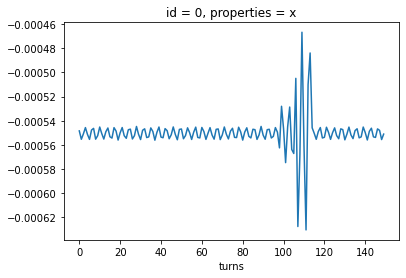

In [8]:
part_array.loc[0, 'x'].plot()

In [9]:
alive_part = []
for turn in range(num_turns):
    alive_part.append(part_array.where(part_array.loc[:, 'state', turn] > 0, drop = True).shape[0])

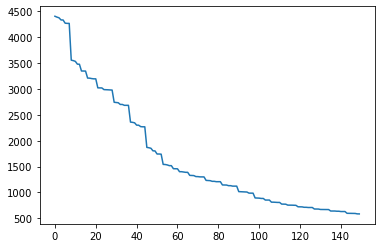

In [10]:
plt.plot(np.arange(num_turns), alive_part)


In [11]:
line_coll = coll_manager.line
twiss=line_coll.twiss()
#TCCS_name = 'tccs.5r3.b2'
beta_y_optics = twiss['bety',0]
critical_angle = np.sqrt(2*16/(line_coll.particle_ref._xobject.p0c[0]*line_coll.particle_ref._xobject.beta0[0]))

normalized_emittance = 3.5e-6
emittance_phy = normalized_emittance/(line_coll.particle_ref._xobject.beta0[0]*line_coll.particle_ref._xobject.gamma0[0])
sigma = np.sqrt(emittance_phy*beta_y_optics)

In [12]:

def plot_distributions_at_turn(arr, turn):
    alive_arr = arr.where(arr.loc[:, 'state', turn] > 0, drop = True)[:,:,1]

    fig1 = plt.figure( figsize=(24, 5))
    ax1 = fig1.add_subplot(1,3,1)
    ax1.hist(alive_arr.loc[:, 'x'], bins=100)
    ax1.set_xlabel('x [mm]')
    ax1.set_ylabel("")
    #ax1.set_yscale("log")
    ax1.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e3:.{1}f}" for x in plt.xticks()[0]])


    ax2 = fig1.add_subplot(1,3,2)
    ax2.hist(alive_arr.loc[:, 'y'], bins=100) 
    ax2.set_xlabel('y [mm]')
    ax2.set_ylabel('')
    #ax2.set_yscale("log")
    ax2.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e3:.{1}f}" for x in plt.xticks()[0]])
    ax2.set_title(f'Total particles: {alive_arr.shape[0]}')

    ax3 = fig1.add_subplot(1,3,3)
    h = ax3.hist2d(alive_arr.loc[:, 'x'], alive_arr.loc[:, 'y'], bins=100, norm=matplotlib.colors.LogNorm(vmin = 1, vmax = 1e6))#, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
    ax3.set_xlabel(r'x [mm]')
    #ax3.set_ylim(0,0.008)
    ax3.set_ylabel(r'y [mm]')
    ax3.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e3:.{1}f}" for x in plt.xticks()[0]])
    ax3.set_yticks(ticks=plt.yticks()[0], labels=[f"{y*1e3:.{1}f}" for y in plt.yticks()[0]])

    axins = inset_axes(ax3, height="100%",  width="5%", loc='right', borderpad=-6 )
    fig1.colorbar(h[3], cax=axins, orientation='vertical', label='Count (log scale)')
    ax3.grid(linestyle=':')

    

    


    """ax3_tw = ax3.twinx()
    ticks = np.arange(1, max(ax3.get_yticks())/sigma+1, 2.0)
    ax3_tw.set_yticks(ticks)
    ax3_tw.set_ylabel(r' n $\sigma$')
    ax3_tw.set_yticklabels([f"{x /sigma :.{0}f}"  for x in ticks])
    ax3_tw.axhline(5, color = 'r', linestyle = '--')
    ax3_tw.text( max(ax3.get_xticks())-1.5e-3, 4, r'TCP $\sigma$')"""
    

    fig1.suptitle('plot')
    plt.show()


    return fig1, [ax1,ax2,ax3]

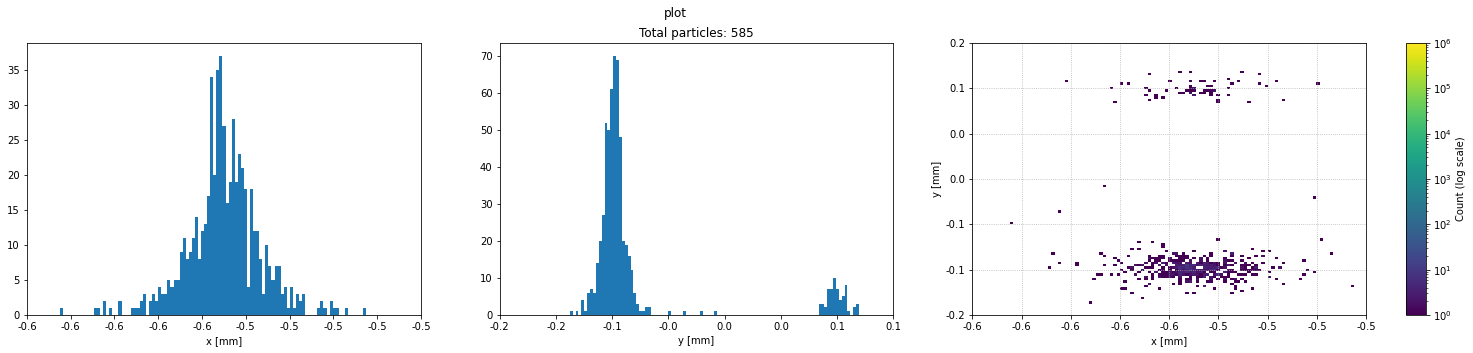

In [13]:
fig, ax_list = plot_distributions_at_turn(part_array, num_turns-1)

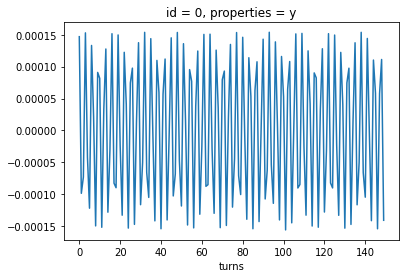

In [325]:
part_array.loc[0, 'y'].plot()

In [301]:
part_array.where(part_array.loc[:, 'state', 1] > 0, drop = True)[:,:,1]

<xarray.DataArray (id: 4389, properties: 6)>
array([[-5.55303685e-04, -9.85754813e-05, -5.37137993e-07,
        -1.94346448e-04,  1.00000000e+00,  0.00000000e+00],
       [-5.19800479e-04, -8.10787776e-05,  1.82423676e-06,
        -2.01944642e-04,  1.00000000e+00,  0.00000000e+00],
       [-5.42599792e-04, -8.59605452e-05,  5.29643732e-07,
        -1.99793707e-04,  1.00000000e+00,  0.00000000e+00],
       ...,
       [-5.55630702e-04,  7.51392828e-05, -2.53485171e-07,
        -6.55748899e-05,  1.00000000e+00,  0.00000000e+00],
       [-5.40933778e-04,  9.70711372e-05,  6.44448830e-07,
        -7.47503339e-05,  1.00000000e+00,  0.00000000e+00],
       [-5.62260318e-04,  1.13209439e-04, -4.04985429e-07,
        -8.15553249e-05,  1.00000000e+00,  0.00000000e+00]])
Coordinates:
  * id          (id) int64 0 1 2 3 4 5 6 ... 4382 4383 4384 4385 4386 4387 4388
  * properties  (properties) <U10 'x' 'y' 'px' 'py' 'state' 'at_element'
    turns       int64 1

#### Saving

In [263]:
part_array.to_netcdf("./Outputdata/part_200turns_5000.nc")

In [7]:
part_array =  xr.open_dataarray("./Outputdata/part_200turns_5000.nc")

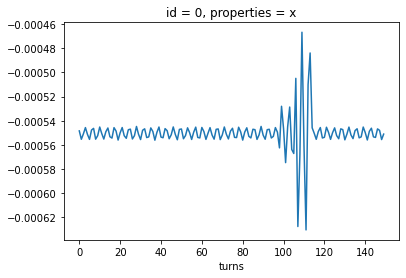

In [267]:
new_part_array.loc[0, 'x'].plot()

In [252]:
part_array.to_dataframe('particles')

particles
id   properties turns              
0    x          0         -0.000548
                1         -0.000555
                2         -0.000551
                3         -0.000546
                4         -0.000551
...                             ...
4999 at_element 145    26838.000000
                146    26838.000000
                147    26838.000000
                148    26838.000000
                149    26838.000000

[4500000 rows x 1 columns]

In [253]:
df_part = part_array.to_dataframe('particles')
df_part.to_hdf('./Outputdata/part_200turns_5000.h5', key='df', mode='w') 

In [254]:
new_df_part = pd.read_hdf('./Outputdata/part_200turns_5000.h5')

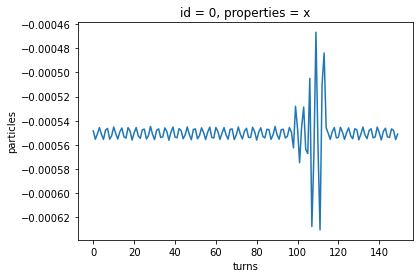

In [262]:
new_df_part["particles"].to_xarray().loc[0, 'x'].plot()

### impact distributions plots

In [ ]:
#df_new =  pd.read_hdf('/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/TEST_B2V_ABS_CRY1__20231113-1818/Job.77/Outputdata/particles_B2V.h5')

In [ ]:
    prefix_name = 'TEST_B2V_ABS_CRY1_5.5_'
    Condor_path = '/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/'
    test_list = [Condor_path + i for i in os.listdir(Condor_path) if prefix_name in i]
    
    for test_name in test_list:

        job_directories = [test_name + '/' + i for i in os.listdir(test_name) if 'Job.' in i]
        n_jobs = len(job_directories)  
        df_particles =  pd.DataFrame()

        n_jobs_verify = 0 

        for job_dir in job_directories:
                part_file = [filename for filename in os.listdir(job_dir +'/Outputdata') if filename.startswith("particles_")]
                if part_file:
                    df_tmp = pd.read_hdf(job_dir +'/Outputdata/' + part_file[0])
                    df_particles = pd.concat([df_particles, df_tmp])
                    n_jobs_verify = n_jobs_verify + 1 


        if n_jobs != n_jobs_verify:
            print("!!! Succesful Jobs: ", n_jobs_verify, '/', n_jobs, ' in file: ', test_name)

In [ ]:
df_particles

,start_tracking_at_element,q0,mass0,s,zeta,chi,charge_ratio,weight,pdg_id,particle_id,...,y,px,py,delta,ptau,rvv,rpp,p0c,beta0,gamma0
0,-1,1.0,9.382721e+08,0.000000,1.626747e-03,1.0,1.0,1.0,0,0,...,0.000154,2.075800e-06,-0.000132,0.000003,2.521238e-06,1.0,0.999997,6.800000e+12,1.0,7247.364689
1,-1,1.0,9.382721e+08,0.000000,1.083218e-03,1.0,1.0,1.0,0,96852,...,-0.000154,1.928001e-06,-0.000137,0.000003,2.829261e-06,1.0,0.999997,6.800000e+12,1.0,7247.364689
2,-1,1.0,9.382721e+08,0.000000,1.095279e-03,1.0,1.0,1.0,0,98717,...,-0.000154,-1.749762e-06,-0.000137,0.000002,1.948604e-06,1.0,0.999998,6.800000e+12,1.0,7247.364689
3,-1,1.0,9.382721e+08,0.000000,5.631893e-03,1.0,1.0,1.0,0,46329,...,0.000151,5.345611e-06,-0.000121,0.000007,6.663331e-06,1.0,0.999993,6.800000e+12,1.0,7247.364689
4,-1,1.0,9.382721e+08,0.000000,1.782314e-03,1.0,1.0,1.0,0,28658,...,0.000154,5.756511e-06,-0.000133,0.000003,3.217580e-06,1.0,0.999997,6.800000e+12,1.0,7247.364689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-1,1.0,9.382721e+08,6459.442798,4.561431e-11,1.0,1.0,1.0,0,16,...,0.000920,4.162148e-08,0.000012,0.000000,0.000000e+00,1.0,1.000000,6.800000e+12,1.0,7247.364689
99996,-1,1.0,9.382721e+08,6459.442798,4.668479e-11,1.0,1.0,1.0,0,15,...,0.000919,4.224676e-08,0.000012,0.000000,-2.117582e-22,1.0,1.000000,6.800000e+12,1.0,7247.364689
99997,-1,1.0,9.382721e+08,6459.442798,4.439795e-11,1.0,1.0,1.0,0,12,...,0.000920,6.706577e-08,0.000012,0.000000,-2.117582e-22,1.0,1.000000,6.800000e+12,1.0,7247.364689
99998,-1,1.0,9.382721e+08,6459.442798,4.553651e-11,1.0,1.0,1.0,0,99998,...,-0.000919,8.485162e-08,-0.000012,0.000000,0.000000e+00,1.0,1.000000,6.800000e+12,1.0,7247.364689


In [19]:
line_coll = coll_manager.line
TCCS_idx = line_coll.element_names.index('tccs.5r3.b2')
cry_impact_parts = df_particles[(df_particles.at_element == TCCS_idx) & (df_particles.state<0)]

In [38]:

line_coll = coll_manager.line
twiss=line_coll.twiss()
TCCS_name = 'tccs.5r3.b2'
beta_y_optics = twiss['bety',TCCS_name]
alfa_y_optics = twiss['alfy',TCCS_name]


critical_angle = np.sqrt(2*16/(line.particle_ref._xobject.p0c[0]*line.particle_ref._xobject.beta0[0]))

normalized_emittance = 3.5e-6
emittance_phy = normalized_emittance/(line.particle_ref._xobject.beta0[0]*line.particle_ref._xobject.gamma0[0])
sigma = np.sqrt(emittance_phy*beta_y_optics)

n_sig = 6.0

py_central = - n_sig * alfa_y_optics * np.sqrt(emittance_phy/beta_y_optics)

4389 0.01


Text(0.5, 0.98, 'CRY 1 at')

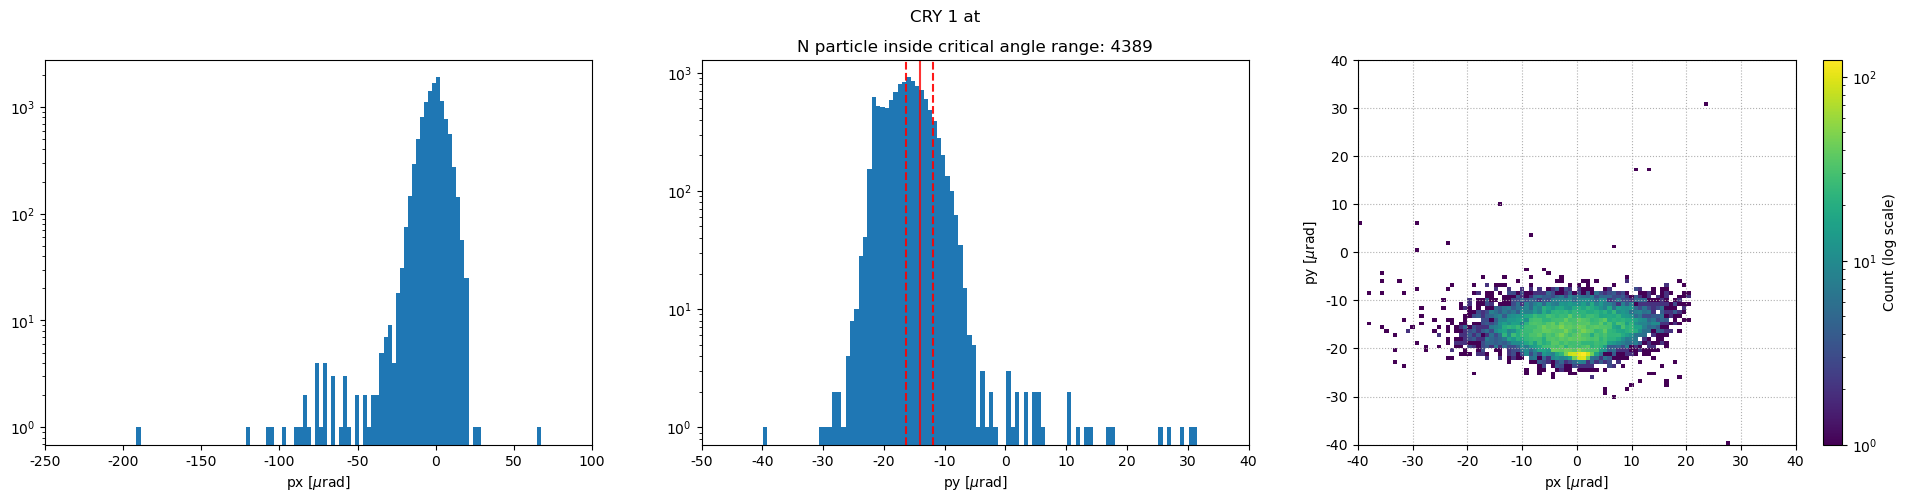

In [67]:

    fig1 = plt.figure( figsize=(24, 5))
    ax1 = fig1.add_subplot(1,3,1)
    ax1.hist(cry_impact_parts['px'], bins=100)
    ax1.set_xlabel(r'px [$\mu$rad]')
    ax1.set_ylabel("")
    ax1.set_yscale("log")
    precision = 6  # Set the desired precision
    ax1.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e6:.{0}f}" for x in plt.xticks()[0]])
    #ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)


    ax2 = fig1.add_subplot(1,3,2)
    ax2.hist(cry_impact_parts['py'], bins=100) 
    ax2.set_xlabel(r'py [$\mu$rad]')
    ax2.set_ylabel('')
    ax2.set_yscale("log")
    ax2.axvline(py_central, color = 'red', linestyle = '-', alpha = 0.8)
    ax2.axvline(py_central + critical_angle, color = 'red', linestyle = '--', alpha = 0.9)
    ax2.axvline(py_central - critical_angle, color = 'red', linestyle = '--', alpha = 0.9)
    ax2.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e6:.{0}f}" for x in plt.xticks()[0]])
    #ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)

    ax3 = fig1.add_subplot(1,3,3)
    h = ax3.hist2d(cry_impact_parts['px'], cry_impact_parts['py'], bins=100, norm=matplotlib.colors.LogNorm(), range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
    ax3.set_xlabel(r'px [$\mu$rad]')
    ax3.set_ylabel(r'py [$\mu$rad]')
    ax3.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e6:.{0}f}" for x in plt.xticks()[0]])
    ax3.set_yticks(ticks=plt.yticks()[0], labels=[f"{y*1e6:.{0}f}" for y in plt.yticks()[0]])
    ax3.grid(linestyle=':')
    fig1.colorbar(h[3], orientation='vertical', label='Count (log scale)')


    chann = len(cry_impact_parts[(cry_impact_parts.py > py_central - critical_angle) & (cry_impact_parts.py < py_central + critical_angle)])
    print(chann, min(ax2.get_yticks()))


    ax2.set_title(f'N particle inside critical angle range: {chann}')

    fig1.suptitle('CRY 1 at')
    #ax3.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
    #ax3.ticklabel_format(style='sci', axis='y'
    # , scilimits=(0,0), useMathText=True)

    #fig1.savefig("./Outputdata/impact_angles_test.png")

Text(0.5, 0.98, 'CRY 1 at')

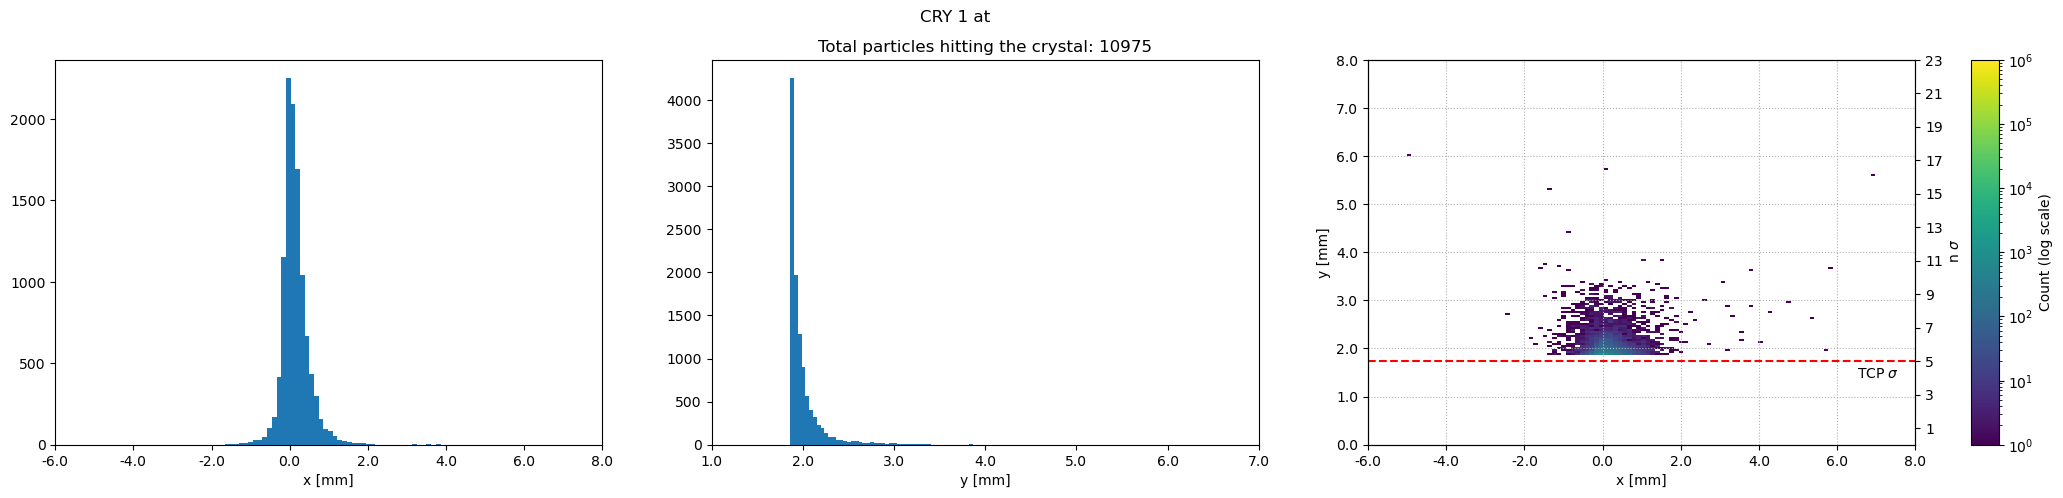

In [66]:
    
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes


    fig1 = plt.figure( figsize=(24, 5))
    ax1 = fig1.add_subplot(1,3,1)
    ax1.hist(cry_impact_parts['x'], bins=100)
    ax1.set_xlabel('x [mm]')
    ax1.set_ylabel("")
    #ax1.set_yscale("log")
    ax1.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e3:.{1}f}" for x in plt.xticks()[0]])


    ax2 = fig1.add_subplot(1,3,2)
    ax2.hist(cry_impact_parts['y'], bins=100) 
    ax2.set_xlabel('y [mm]')
    ax2.set_ylabel('')
    #ax2.set_yscale("log")
    ax2.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e3:.{1}f}" for x in plt.xticks()[0]])
    ax2.set_title(f'Total particles hitting the crystal: {len(cry_impact_parts)}')

    ax3 = fig1.add_subplot(1,3,3)
    h = ax3.hist2d(cry_impact_parts['x'], cry_impact_parts['y'], bins=100, norm=matplotlib.colors.LogNorm(vmin = 1, vmax = 1e6))#, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
    ax3.set_xlabel(r'x [mm]')
    ax3.set_ylim(0,0.008)
    ax3.set_ylabel(r'y [mm]')
    ax3.set_xticks(ticks=plt.xticks()[0], labels=[f"{x*1e3:.{1}f}" for x in plt.xticks()[0]])
    ax3.set_yticks(ticks=plt.yticks()[0], labels=[f"{y*1e3:.{1}f}" for y in plt.yticks()[0]])

    axins = inset_axes(ax3, height="100%",  width="5%", loc='right', borderpad=-6 )

    fig1.colorbar(h[3], cax=axins, orientation='vertical', label='Count (log scale)')


    ax3_tw = ax3.twinx()
    ticks = np.arange(1, max(ax3.get_yticks())/sigma+1, 2.0)
   
    ax3_tw.set_yticks(ticks)
    #ax3_tw.set_ybound(ax3.get_ybound())
    ax3_tw.set_ylabel(r' n $\sigma$')
    #ax3_tw.set_yticklabels([f"{x /sigma :.{0}f}"  for x in ticks])
    ax3_tw.axhline(5, color = 'r', linestyle = '--')
    ax3_tw.text( max(ax3.get_xticks())-1.5e-3, 4, r'TCP $\sigma$')
    ax3.grid(linestyle=':')

    fig1.suptitle('CRY 1 at')


    #fig1.savefig("./Outputdata/impact_position_test.png")

### Line Analysis

In [ ]:
stop = line.element_names.index('tcla.a5l3.b2')
start = line.element_names.index('tcsg.5r3.b2')

In [ ]:
for i in range(start-400, stop+400):
    if (line.element_names[i].endswith('b2') and type(line[i]) !=  xt.beam_elements.elements.Marker) or line.element_names[i].startswith('ip'):
        print(line.element_names[i], '\t\t', end_s-line.get_s_elements()[i], '\t\t', line[i].__class__.__name__ )

mbw.d6r3.b2 		 6847.564790687997 		 Multipole
tcp.6r3.b2 		 6842.070291762997 		 EverestCollimator
tcapa.6r3.b2 		 6832.893793852007 		 Drift
mbw.c6r3.b2 		 6829.5417939640065 		 Multipole
mbw.b6r3.b2 		 6825.306793964006 		 Multipole
mbw.a6r3.b2 		 6821.071793964005 		 Multipole
bpmwe.a5r3.b2 		 6818.556293964008 		 Drift
tcapd.5r3.b2 		 6817.771793964006 		 Drift
tcsg.5r3.b2 		 6808.948793964006 		 EverestCollimator
bpmw.5r3.b2 		 6789.838293964007 		 Drift
mcbwv.5r3.b2 		 6786.043793964007 		 Multipole
tccs.5r3.b2 		 6773.702000000001 		 EverestCrystal
bpmwe.4r3.b2 		 6714.710293964006 		 Drift
bpmw.4r3.b2 		 6687.165293964008 		 Drift
mcbwh.4r3.b2 		 6683.420793964007 		 Multipole
ip3_aper 		 6664.720793964007 		 LimitRectEllipse
ip3 		 6664.720793964007 		 Marker
target.4l3.b2 		 6653.34 		 EverestCollimator
tccp.4l3.b2 		 6653.334999999999 		 EverestCrystal
mcbwv.4l3.b2 		 6643.690793964008 		 Multipole
bpmw.4l3.b2 		 6642.200293964008 		 Drift
tcsg.4l3.b2 		 6622.365793964007 		

# Load LOSSMAPS

In [2]:
path = '/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/'

In [3]:
n_test = 'TEST_B2V_align_test_CRY6.0'
prefix_name =  'TEST_B2V_align_test_CRY5.0_15_'

In [4]:
#n_old = int(subprocess.check_output("find "+ path + n_test +" -maxdepth 1 -mindepth 1 -type d | wc -l", shell=True))
#n = int(subprocess.check_output("find "+ path + n_test +" -maxdepth 1 -mindepth 1 -type d | grep Job. | wc -l", shell=True))
test_list = (subprocess.check_output("find "+ path +" -maxdepth 1 -mindepth 1 -type d | grep " + prefix_name, shell=True)).decode('ascii').strip().splitlines()

In [5]:
test_list

['/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/TEST_B2V_align_test_CRY5.0_15__20231110-1733']

In [6]:
    for test_name in test_list:

        n_jobs = int(subprocess.check_output("find "+ test_name +" -maxdepth 1 -mindepth 1 -type d | grep Job. | wc -l", shell=True))

        losses_json =[]

        for i in range(n_jobs):
            file_path = (subprocess.check_output("echo " + test_name + '/Job.' + str(i) + '/Outputdata/lossmap*.json', shell=True)).decode('ascii').strip()
            if os.path.exists(file_path):
                losses_json.append(file_path)

        n_jobs_verify  = len(losses_json)
        if n_jobs != n_jobs_verify:
            print("!!! Succesful Jobs: ", n_jobs_verify, '/', n_jobs, ' in file: ', test_name)

In [7]:
losses_json

['/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/TEST_B2V_align_test_CRY5.0_15__20231110-1733/Job.0/Outputdata/lossmap_B2V.json',
 '/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/TEST_B2V_align_test_CRY5.0_15__20231110-1733/Job.1/Outputdata/lossmap_B2V.json',
 '/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/TEST_B2V_align_test_CRY5.0_15__20231110-1733/Job.2/Outputdata/lossmap_B2V.json',
 '/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/TEST_B2V_align_test_CRY5.0_15__20231110-1733/Job.3/Outputdata/lossmap_B2V.json',
 '/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/TEST_B2V_align_test_CRY5.0_15__20231110-1733/Job.4/Outputdata/lossmap_B2V.json',
 '/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/TEST_B2V_align_test_CRY5.0_15__20231110-1733/Job.5/Outputdata/lossmap_B2V.json',
 '/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/TEST_B2V_align_test_CRY5.0_15__20231110-1733/Job.6/Outputdata/lossmap_B2V.json',

In [8]:
ThisLM = lm.SimulatedLossMap(lmtype=lm.LMType.B2V, machine=lm.Machine.LHC)

In [9]:
#ThisLM.load_data_json(json_files=losses_json)
ThisLM.load_data_json(json_files=losses_json)

Maximum inefficiency in the DS is 2.04e-05.


pymadx.Tfs.Load> normal file


(<Figure size 1440x864 with 3 Axes>,
 array([<Axes: xlabel='S [m]', ylabel='Norm. inefficiency [arb. unit]'>,
        <Axes: >,
        <Axes: xlabel='S [m]', ylabel='Norm. inefficiency [arb. unit]'>],
       dtype=object))

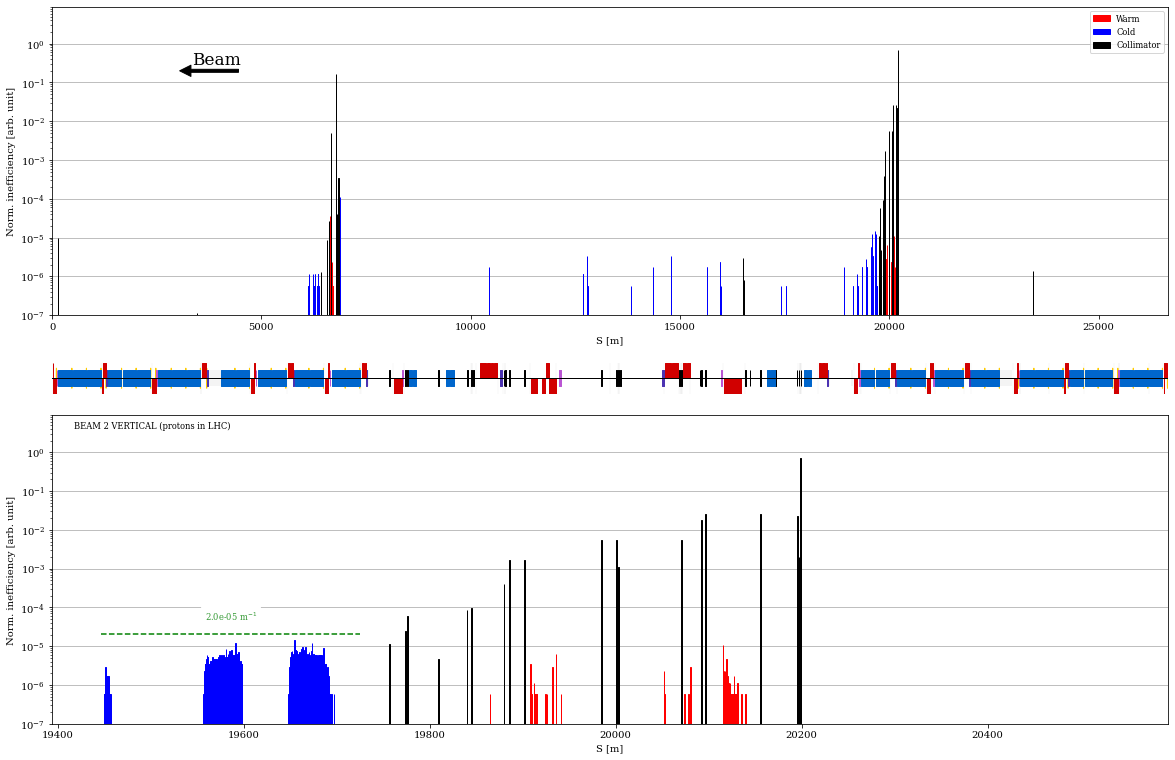

In [10]:
lm.plot_lossmap(ThisLM, zoom=True, layout="./input_files/layout_flat_top_b2.tfs",  outfile = "./Outputdata/TEST_False2.png")  #, outfile = "./Outputdata/Lossmap_outputs/"+outfile_name

In [11]:
lm.plot_lossmap_interactive(ThisLM, norm='total', layout="./input_files/layout_flat_top_b2.tfs")  #

Box(children=(Dropdown(description='norm', index=3, options=('none', 'max', 'coll_max', 'total'), value='total…

FigureWidget({
    'data': [{'base': 1e-17,
              'hovertemplate': 'S=%{x:.2f} m, value=%{y:1.2e}<br>%{hovertext}',
              'hovertext': array([ 166.,  167.,  168.,  169.,  170.,  171.,  172.,  173.,  174.,  175.,
                                   177.,  178.,  179.,  180.,  181.,  182.,  183.,  184.,  185.,  186.,
                                   187.,  188.,  189.,  190.,  191.,  192.,  193.,  194.,  195.,  196.,
                                   197.,  198.,  199.,  200.,  201.,  204.,  239.,  240.,  241.,  242.,
                                  1269., 1273., 1274., 1275., 1276., 1277., 1278., 1279., 1280., 1281.,
                                  1282., 1283., 1284., 1285., 1286., 1287., 1288., 1292., 1293., 1295.,
                                  1296., 1297., 1298., 1301., 1302., 1303., 1304., 1305., 1306., 1307.,
                                  1308., 1309., 1310., 1311., 1312., 1313., 1314., 1315., 1316., 1317.,
                                  1318., 131

In [12]:
losses_df = ThisLM._losses
losses_df[losses_df['name']=='tcla.a5l3.b2']

#'target.4l3.b2'

#loss_tcp = int(losses_df[losses_df['name']=='tcp.d6r7.b2']['losses'])

,s,name,losses_type,losses
162,6574.220794,tcla.a5l3.b2,Losses.COLL,152.0


### PYMADX

In [ ]:
loss_cry1/loss_tcp

In [ ]:
import pymadx
name_pymadx_layout = "input_files/layout_file_b2_flattop.tfs"  
tfsobject= pymadx.Data.Tfs(name_pymadx_layout)

pymadx.Tfs.Load> normal file


In [ ]:
for i in tfsobject:
    print(i['S'])

In [ ]:
if tfsobject.header['SEQUENCE'] == 'LHCB2':
    machine_length = tfsobject.header['LENGTH']
    print("------------- BEAM2 LAYOUT INVERTED -------------")
    for i in range(len(tfsobject)):
        old_s = tfsobject[i]['S']
        tfsobject.EditComponent(i,'S', machine_length-old_s) 

In [ ]:
for i in tfsobject:
    print(i['S'])

In [ ]:
def _get_twiss_header(tfsfile):
    header = None
    line_no = 0

    gzipped = tfsfile.endswith(".gz")
    fopen = gzip.open if gzipped else open

    flag = "rb" if gzipped else "r"
    with fopen(tfsfile, flag) as filein:
        for idx, line in enumerate(filein):
            if gzipped:
                line = line.decode("utf-8")
            if line.startswith("*"):  # This is the header line, preamble lines start with @
                header = line.replace("*", "").strip().split()  # Strip the comment char
                line_no = idx + 1  # As zero counted
                break  # End the loop early - information found

    return header, line_no



def _load_layout_tfs(tfsfile):
    header, header_line_no = _get_twiss_header(tfsfile)

    required_columns = {"KEYWORD", "S", "L", "K1L", "NAME"}

    if not required_columns.issubset(set(required_columns)):
        raise KeyError("The required columns in the MAD-X"
                       " TFS file are: {}".format(" ".join(list(required_columns))))

    twiss = pd.read_csv(tfsfile, delim_whitespace=True, skiprows=header_line_no+1,
                        index_col=False, names=header)

    twiss = twiss[list(required_columns)] # Reduce the data fields
    twiss["NAME"] = twiss["NAME"].str.upper() # Make the names uppercase
    twiss = twiss.set_index("NAME")

    return twiss



def _make_layout_plotly(tfsfile):
    tfs_df = _load_layout_tfs(tfsfile)
    tfs_df = tfs_df[(tfs_df["L"] > 0) & (tfs_df["KEYWORD"] != "DRIFT")]

    lim = (tfs_df["S"].min(), tfs_df["S"].max())
    centres = tfs_df["S"] - tfs_df["L"]/2


In [ ]:
'LENGTH' in _get_twiss_header(name_pymadx_layout)[0]

False

In [ ]:
_get_twiss_header(name_pymadx_layout)

(['NAME',
  'KEYWORD',
  'S',
  'L',
  'K0L',
  'K1L',
  'K2L',
  'K3L',
  'K4L',
  'K1SL',
  'K2SL',
  'K3SL',
  'K4SL',
  'HKICK',
  'VKICK',
  'BETX',
  'BETY',
  'ALFX',
  'ALFY',
  'MUX',
  'MUY',
  'DX',
  'DY',
  'DPX',
  'DPY',
  'R11',
  'R12',
  'R22',
  'R21',
  'X',
  'PX',
  'Y',
  'PY',
  'T',
  'PT',
  'DELTAP',
  'VOLT',
  'LAG',
  'HARMON',
  'FREQ',
  'E1',
  'E2',
  'APERTYPE',
  'APER_1',
  'APER_2',
  'APER_3',
  'APER_4',
  'TILT',
  'ANGLE'],
 51)